## SciPy

Convert the all_lights matrix to a sparse one by centering its observations in a way that maximizes the number of zero elements. Repeat Exercise 2 above, using the sparse matrix utilities of SciPy.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# Load light data
all_light = np.loadtxt('intel_lab/light.txt')
all_light.shape

print("Original #non-zeros:", np.count_nonzero(all_light))
print("Original #zeros:", all_light.size - np.count_nonzero(all_light))

Original #non-zeros: 22202
Original #zeros: 1174


In [3]:
def center_by_mode(matrix, axis=0):
    """
    Subtract the mode value along `axis` of the matrix.
    axis=0 => column-wise mode, subtract each column's mode from that column.
    axis=1 => row-wise mode, subtract each row's mode from that row.
    """
    centered = matrix.copy()
    if axis == 0:
        # Column-wise
        n_cols = centered.shape[1]
        for j in range(n_cols):
            col = centered[:, j]
            mode_res = st.mode(col, keepdims=True)
            mode_val = mode_res.mode[0]
            col -= mode_val
    elif axis == 1:
        # Row-wise
        n_rows = centered.shape[0]
        for i in range(n_rows):
            row = centered[i, :]
            mode_res = st.mode(row, keepdims=True)
            mode_val = mode_res.mode[0]
            row -= mode_val
    return centered

def center_maximize_zeros(matrix):
    """
    1) Center by row-mode => count zeros
    2) Center by column-mode => count zeros
    4) Return whichever yields more zeros
    """
    # Row-mode
    centered_row = center_by_mode(matrix, axis=1)
    nonzeros_row = np.count_nonzero(centered_row)
    zeros_row = matrix.size - nonzeros_row
    
    # Column-mode
    centered_col = center_by_mode(matrix, axis=0)
    nonzeros_col = np.count_nonzero(centered_col)
    zeros_col = matrix.size - nonzeros_col

    # Print summary
    print(f"After row-mode centering: zeros={zeros_row}, nonzeros={nonzeros_row}")
    print(f"After column-mode centering: zeros={zeros_col}, nonzeros={nonzeros_col}")

    # Choose whichever yields more zeros
    if zeros_row >= zeros_col:
        print("Row-mode centering yields more (or equal) zeros. Returning row-centered matrix.")
        return centered_row
    else:
        print("Column-mode centering yields more zeros. Returning column-centered matrix.")
        return centered_col

# best centered matrix
best_centered = center_maximize_zeros(all_light)

After row-mode centering: zeros=2309, nonzeros=21067
After column-mode centering: zeros=17088, nonzeros=6288
Column-mode centering yields more zeros. Returning column-centered matrix.


In [5]:
from scipy.sparse import csr_matrix

light_sparse = csr_matrix(best_centered)

print(light_sparse)
# <487x48 sparse matrix of type '<class 'numpy.float64'>' 
# with NNZ stored elements in Compressed Sparse Row format>

# non-zero stored elements
nnz = light_sparse.nnz
print("Non-zero entries in sparse matrix:", nnz)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6288 stored elements and shape (487, 48)>
  Coords	Values
  (0, 0)	-43.24
  (0, 1)	-121.44
  (0, 2)	-48.76
  (0, 3)	-97.52
  (0, 5)	-114.08
  (0, 6)	-97.52
  (0, 7)	-108.56
  (0, 8)	-104.88
  (0, 9)	-53.36
  (0, 10)	476.09999999999997
  (0, 11)	39.1
  (0, 12)	-1.38
  (0, 13)	-0.46
  (0, 14)	-1.84
  (0, 15)	-1.38
  (0, 16)	-7.36
  (0, 17)	-2.76
  (0, 18)	39.56
  (0, 19)	-150.88
  (0, 20)	-67.16
  (0, 21)	-79.12
  (0, 22)	-224.48
  (0, 23)	-136.16
  (0, 24)	-101.2
  (0, 25)	-114.08
  :	:
  (485, 38)	-7.360000000000014
  (485, 39)	-7.360000000000014
  (485, 41)	-14.71999999999997
  (485, 42)	-14.720000000000027
  (485, 43)	-3.6799999999999926
  (485, 45)	-5.519999999999996
  (485, 46)	-29.43999999999994
  (485, 47)	-5.519999999999996
  (486, 5)	-5.519999999999996
  (486, 8)	-3.6799999999999926
  (486, 14)	-0.4600000000000002
  (486, 21)	-3.680000000000007
  (486, 22)	-7.359999999999985
  (486, 29)	-3.680000000000007
  (486, 31)

In [6]:
# Find neighbors of mote 37

locs = np.loadtxt('intel_lab/mote_locs.txt')  # shape (54,3)
print(locs.shape)

row_37 = locs[ locs[:, 0] == 37 ]
mote37_id, mote37_x, mote37_y = row_37[0]

distances = []
for row in locs:
    mote_id, x, y = row
    if mote_id == 37:
        continue
    dist = np.linalg.norm([mote37_x - x, mote37_y - y])
    distances.append((dist, int(mote_id)))

distances.sort(key=lambda d: d[0])
neighbors_4 = distances[:4]
neighbor_ids = [nb[1] for nb in neighbors_4]
print("Neighbors of mote 37:", neighbor_ids)

motes_of_interest = [37] + neighbor_ids

(54, 3)
Neighbors of mote 37: [39, 35, 36, 38]


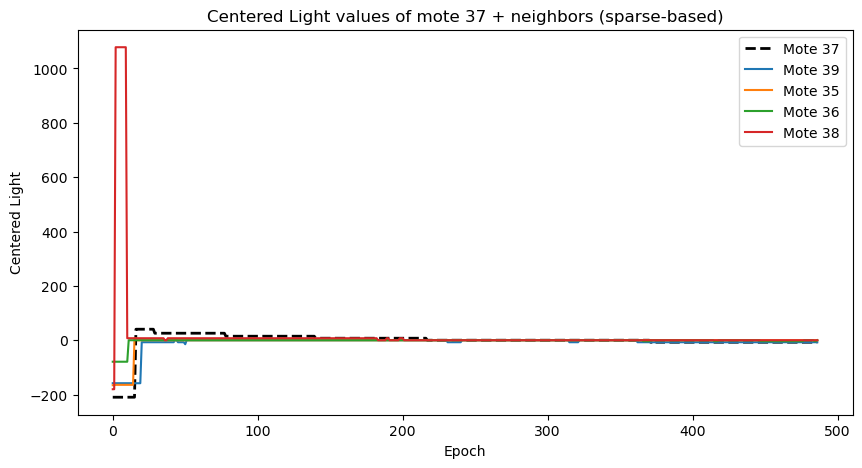

In [ ]:
def extract_mote_timeseries(sparse_mat, mote_id):
    """
    Return a dense 1D array of the entire time series for 'mote_id'.
    """
    col_index = mote_id - 1
    # slice => shape (487, 1) as a sub-sparse matrix
    sub_col = sparse_mat[:, col_index]
    # Convert to dense
    arr = sub_col.toarray().ravel()   # shape (487,)
    return arr

# Gather the time series for the 5 motes
light_arrays = []
for mid in motes_of_interest:
    arr = extract_mote_timeseries(light_sparse, mid)
    light_arrays.append(arr)

# Optionally, plot them:
plt.figure(figsize=(10, 5))
for i, arr in enumerate(light_arrays):
    label = f"Mote {motes_of_interest[i]}"
    if i == 0:
        plt.plot(arr, label=label, color='black', linewidth=2, linestyle='dashed')
    else:
        plt.plot(arr, label=label)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Centered Light')
plt.title('Centered Light values of mote 37 + neighbors (sparse-based)')
plt.show()


In [ ]:
# 4.1. Shapiro–Wilk for normality
for i, arr in enumerate(light_arrays):
    stat, p = st.shapiro(arr)
    print(f"Mote {motes_of_interest[i]} | Shapiro p = {p:.3g}")

# 4.2. ANOVA
stat_f, p_f = st.f_oneway(*light_arrays)
print("ANOVA p-value:", p_f)

# 4.3. Kruskal–Wallis
stat_kw, p_kw = st.kruskal(*light_arrays)
print("Kruskal–Wallis p-value:", p_kw)

# The raw light measurements of mote 37 and its four nearest neighbors
# do not share the same distribution. (p < 1e-100) that at least one mote
# differs significantly from the others.


Mote 37 | Shapiro p = 6.85e-37
Mote 39 | Shapiro p = 7.7e-40
Mote 35 | Shapiro p = 1.02e-41
Mote 36 | Shapiro p = 8.87e-42
Mote 38 | Shapiro p = 2.39e-42
ANOVA p-value: 5.689093729603908e-11
Kruskal–Wallis p-value: 2.9881185977664943e-109


In [ ]:
import scipy.fft as spfft

def segment_fft_summaries(arr, n_segments=10, top_k=10):
    seg_len = len(arr) // n_segments
    summaries = []
    start = 0
    for i in range(n_segments):
        end = start + seg_len
        if i == n_segments - 1:
            end = len(arr)
        segment = arr[start:end]
        start = end

        dft_vals = spfft.rfft(segment)
        magnitudes = np.abs(dft_vals)
        top_mags = np.sort(magnitudes)[-top_k:]
        summary = np.sum(top_mags)
        summaries.append(summary)
    return np.array(summaries)

# Build the summary arrays
all_mote_summaries = []
for arr in light_arrays:
    summaries = segment_fft_summaries(arr, n_segments=10, top_k=10)
    all_mote_summaries.append(summaries)

# Check normality
for i, sums_ in enumerate(all_mote_summaries):
    stat, p = st.shapiro(sums_)
    print(f"Mote {motes_of_interest[i]}, DFT-based summary, Shapiro p={p:.3g}")

# ANOVA
stat_anova, p_anova = st.f_oneway(*all_mote_summaries)
print("ANOVA p-value (DFT-based):", p_anova)

# Kruskal–Wallis
stat_kruskal, p_kruskal = st.kruskal(*all_mote_summaries)
print("Kruskal–Wallis p-value (DFT-based):", p_kruskal)


#Even in the frequency domain (with top‐k amplitude summaries), the data also appear non‐normal, 
# so Kruskal–Wallis is the more appropriate test. Here, p=0.016 means we still reject the null
# of “all motes have identical distributions” (though less dramatically than in the raw data).


Mote 37, DFT-based summary, Shapiro p=1.8e-06
Mote 39, DFT-based summary, Shapiro p=4.25e-07
Mote 35, DFT-based summary, Shapiro p=1e-07
Mote 36, DFT-based summary, Shapiro p=4.85e-07
Mote 38, DFT-based summary, Shapiro p=1.37e-07
ANOVA p-value (DFT-based): 0.6442588035202859
Kruskal–Wallis p-value (DFT-based): 0.016417876768938917
